# Compound Transformer

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from Quantum_circuits import *

## Load the data and preprocess

In [2]:
# load a portion of the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:10000]
y_train = y_train[:10000]

x_test = x_test[:2500]
y_test = y_test[:2500]

# Rescale the images from [0,255] to the [0,1] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [3]:
# keep only 3 and 6
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 2046
Number of filtered test examples: 479


True


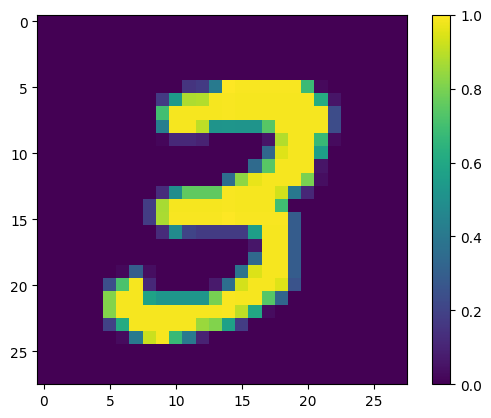

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [6]:
# resize the image to be 8x8
x_train_small = tf.image.resize(x_train, (8,8)).numpy()
x_test_small = tf.image.resize(x_test, (8,8)).numpy()
# resize the image to be 6x6 by cutting out edges
x_train_small = x_train_small[:, 1:7, 1:7, :]
x_test = x_test[:, 1:7, 1:7, :]

True


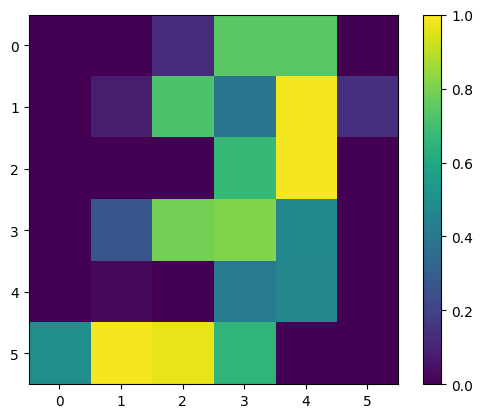

In [7]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [8]:
# remove contraddiction as suggested by tensorflow quantum documentation
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [9]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 2046
Number of unique 3s:  1032
Number of unique 6s:  1014
Number of unique contradicting labels (both 3 and 6):  0

Initial number of images:  2046
Remaining non-contradicting unique images:  2046


## Check that matrix loader works properly

In [10]:
mag_alphas, alphas = convert_matrix(x_train_nocon[0,:,:,0])

# Replace nan values with pi/2
replacement_value = 1.5707964e+00
alphas = tf.where(tf.math.is_nan(alphas), replacement_value, alphas)
mag_alphas = tf.where(tf.math.is_nan(mag_alphas), replacement_value, mag_alphas)

mag_alphas, alphas

(<tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([1.2042221 , 1.0859334 , 1.0596122 , 0.94135934, 1.2001562 ],
       dtype=float32)>,
 <tf.Tensor: shape=(6, 5), dtype=float32, numpy=
 array([[1.5707964 , 1.5707964 , 1.454635  , 0.78539824, 0.        ],
        [1.5707964 , 1.5076796 , 0.9777646 , 1.1974605 , 0.13693103],
        [1.5707964 , 1.5707964 , 1.5707964 , 0.97442746, 0.        ],
        [1.5707964 , 1.3530278 , 0.8700232 , 0.5207384 , 0.        ],
        [1.5707964 , 1.538949  , 1.5707964 , 0.8416063 , 0.        ],
        [1.2572571 , 0.86649024, 0.59606844, 0.        , 0.        ]],
       dtype=float32)>)

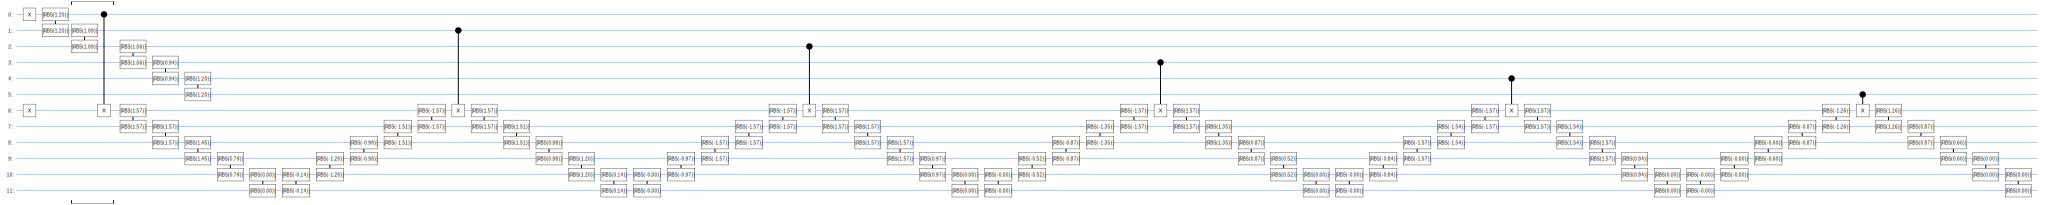

In [11]:
#Circuit to load the matrix
circuit = cirq.Circuit()
matrix_loader(circuit, mag_alphas , alphas, mag_wires = [i for i in range(6)],  wires = [i + 6 for i in range(6)], is_conjugate=False)
SVGCircuit(circuit)

## Convert test set images to circuits

In [12]:
def convert_to_circuit(image):
    #initialize circuit
    circuit = cirq.Circuit()
    mag_wires = [i for i in range(6)]
    wires = [i + 6 for i in range(6)]
    mag_alphas, alphas = convert_matrix(image[:,:,0])
    matrix_loader(circuit, mag_alphas , alphas, mag_wires = mag_wires,  wires = wires, is_conjugate=False)
    return cirq.Circuit(cirq.decompose(circuit)) # circuit must be decomposed in order to be convertible to tensor
convert_to_circuit(x_train_small[0])
x_train_circ = [convert_to_circuit(x) for x in x_train_nocon]
x_test_circ = [convert_to_circuit(x) for x in x_test_small]

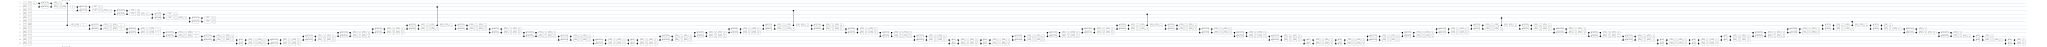

In [13]:
SVGCircuit(x_train_circ[0])

In [14]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
del x_train_circ # free the RAM
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)
del x_test_circ

## Build the orthogonal layer

In [15]:
def build_rbs(circuit, q0, q1, symbol):
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.ry(symbol / 2)(q0), cirq.ry(-symbol / 2)(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))

In [16]:
def pyramid_circuit(circuit, parameters, wires):
    length = len(wires)
    k = 0  
    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)
        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < len(parameters):
                    build_rbs(circuit, wires[_], wires[_ + 1], parameters[k])
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < len(parameters):
                    build_rbs(circuit, wires[_], wires[_ + 1], parameters[k])
                    k += 1

class CircuitLayerBuilder():
    def __init__(self, data_qubits):
        self.data_qubits = data_qubits

    def add_layer(self, circuit, gate, prefix):
        n_parameters = int(len(self.data_qubits) * (len(self.data_qubits) -1) / 2) #paper formula for Number of Gates in a pyramid circuit
        parameters = [sympy.Symbol(prefix + '-' + str(i )) for i in range(n_parameters)]
        pyramid_circuit(circuit, parameters, wires=self.data_qubits)

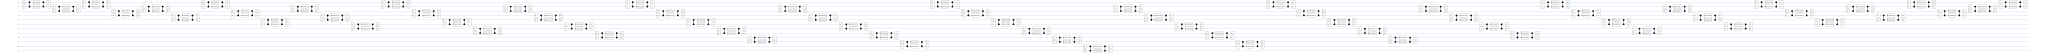

In [17]:
demo_builder = CircuitLayerBuilder(data_qubits = [cirq.LineQubit(i) for i in range(12)])

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

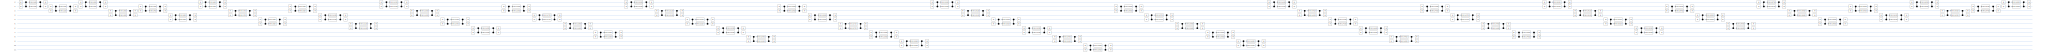

In [18]:
def create_quantum_model(num_qubits=12, layers=[("XX", cirq.XX)]):
    # Initialize qubits.
    data_qubits = [cirq.LineQubit(i) for i in range(num_qubits)]
    
    # Define the circuit.
    circuit = cirq.Circuit()
    
    # Instance of CircuitLayerBuilder
    builder = CircuitLayerBuilder(data_qubits=data_qubits)
    
    # Add specified layers.
    for prefix, gate in layers:
        builder.add_layer(circuit, gate, prefix)

    # Measurement for all qubits
    readout = [cirq.Z(q) for q in data_qubits]

    return circuit, readout
    
# Example usage of model creation function
num_qubits = 12
layers = [("xx1", cirq.XX)]  
model_circuit, model_readout = create_quantum_model(num_qubits=num_qubits, layers=layers)
SVGCircuit(model_circuit)

In [19]:
model_circuit, model_readout = create_quantum_model()

## Build and train the model

In [20]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout, initializer=tf.keras.initializers.RandomUniform(minval=-np.pi/2, maxval=np.pi/2)),
    # Lambda layer to bring the output to [0,1] range
    tf.keras.layers.Lambda(lambda x: (x + 1) / 2),
    # Dense layer with sigmoid activation
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [21]:
# Compile the model
model.compile(
    loss='MSE',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    metrics=['accuracy']
)

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 12)                66        
                                                                 
 lambda (Lambda)             (None, 12)                0         
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
EPOCHS = 30
BATCH_SIZE = 4
NUM_EXAMPLES = min(len(x_train_tfcirc), len(y_train))

In [24]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_sub = y_train[:NUM_EXAMPLES]

In [25]:
qnn_history = model.fit(
    x_train_tfcirc, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test_tfcirc, y_test))

Epoch 1/30
512/512 [==============================] - 75s 146ms/step - loss: 0.2409 - accuracy: 0.6158 - val_loss: 0.2503 - val_accuracy: 0.5386
Epoch 2/30
512/512 [==============================] - 78s 152ms/step - loss: 0.2258 - accuracy: 0.7053 - val_loss: 0.2430 - val_accuracy: 0.5532
Epoch 3/30
512/512 [==============================] - 78s 151ms/step - loss: 0.2198 - accuracy: 0.7419 - val_loss: 0.2421 - val_accuracy: 0.5699
Epoch 4/30
512/512 [==============================] - 72s 141ms/step - loss: 0.2132 - accuracy: 0.7375 - val_loss: 0.2412 - val_accuracy: 0.5532
Epoch 5/30
512/512 [==============================] - 72s 140ms/step - loss: 0.2077 - accuracy: 0.7463 - val_loss: 0.2384 - val_accuracy: 0.5720
Epoch 6/30
512/512 [==============================] - 71s 139ms/step - loss: 0.2040 - accuracy: 0.7683 - val_loss: 0.2384 - val_accuracy: 0.5866
Epoch 7/30
512/512 [==============================] - 79s 155ms/step - loss: 0.1998 - accuracy: 0.7820 - val_loss: 0.2382 - val_ac

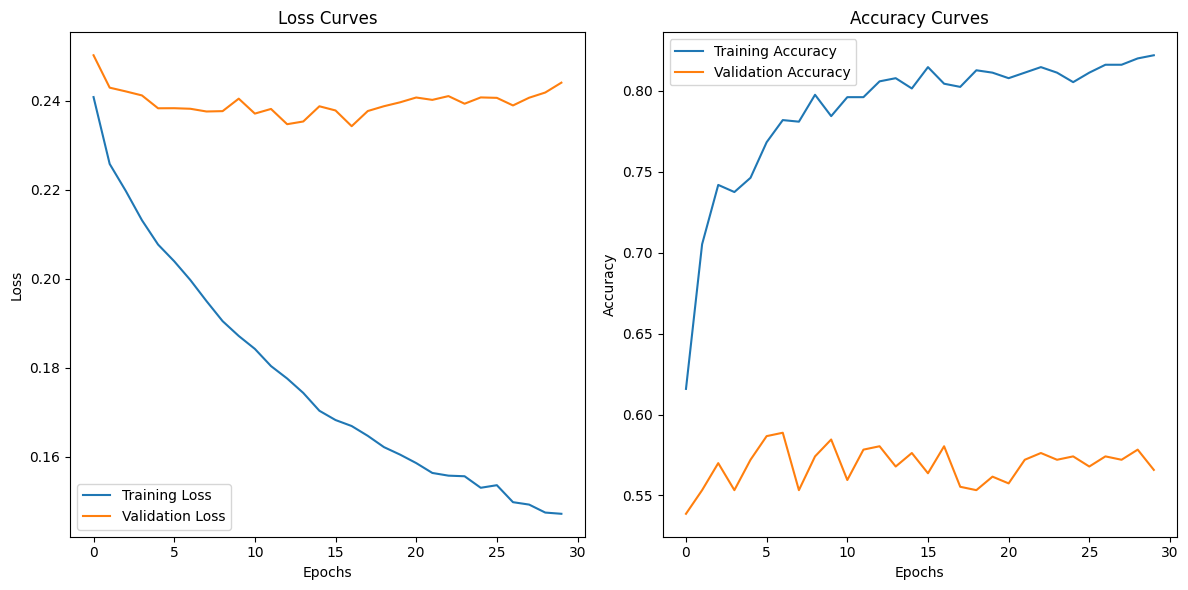

In [26]:
# Plotting loss curves
qnn_history = qnn_history.history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(qnn_history['loss'], label='Training Loss')
plt.plot(qnn_history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(qnn_history['accuracy'], label='Training Accuracy')
plt.plot(qnn_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()